In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
from mnist import save_model
from mnist import load_model
from mnist import eval
from mnist import visualize_example

In [3]:
TRAIN_VAL_SPLIT_PERCENTAGE = 80 # 20
BATCH = 25
SHUFFLE_BUFFER_SIZE = 512

dataset_builder = tfds.builder(name="mnist")
dataset_builder.download_and_prepare()
info = dataset_builder.info
nb_train_examples = info.splits['train'].num_examples * (TRAIN_VAL_SPLIT_PERCENTAGE/100)
nb_val_examples = info.splits['train'].num_examples * ((100-TRAIN_VAL_SPLIT_PERCENTAGE)/100)
nb_test_examples = info.splits['test'].num_examples

# as_supervised is needed otherwise we need to work with dictionaries
ds_train = dataset_builder.as_dataset(split="train[:{}%]".format(TRAIN_VAL_SPLIT_PERCENTAGE),
                                      shuffle_files=True,
                                      batch_size=BATCH,
                                      as_supervised=True)
ds_train = ds_train.repeat()
# Normalize
ds_train = ds_train.map(lambda img, label: (tf.cast(img,tf.float32) / 255.0, label))
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = dataset_builder.as_dataset(split="train[{}%:]".format(TRAIN_VAL_SPLIT_PERCENTAGE),
                                   as_supervised=True,
                                   batch_size=BATCH,)
# Normalize
ds_val = ds_val.map(lambda img, label: (tf.cast(img,tf.float32) / 255.0, label))
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = dataset_builder.as_dataset(split="test", as_supervised=True)
# Normalize
ds_test = ds_test.map(lambda img, label: (tf.cast(img,tf.float32) / 255.0, label))

#viz = dataset_builder.as_dataset(split="test")
#fig = tfds.show_examples(info, viz)

In [4]:
_input = tf.keras.layers.Input((28,28,1))
x = tf.keras.layers.Conv2D(8, (3,3))(_input)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(16, (3,3))(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(32, (3,3))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.3)(x, training=True)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Dropout(0.3)(x, training=True)
output = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=_input, outputs=output)

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['acc'])

In [5]:
model.fit(ds_train, epochs=15, steps_per_epoch=nb_train_examples/BATCH,
         validation_data=ds_val, verbose=2)

Train for 1920.0 steps
Epoch 1/15
1920/1920 - 8s - loss: 0.2306 - acc: 0.9296 - val_loss: 0.1344 - val_acc: 0.9587
Epoch 2/15
1920/1920 - 7s - loss: 0.1247 - acc: 0.9628 - val_loss: 0.1095 - val_acc: 0.9668
Epoch 3/15
1920/1920 - 7s - loss: 0.1067 - acc: 0.9690 - val_loss: 0.1099 - val_acc: 0.9652
Epoch 4/15
1920/1920 - 6s - loss: 0.0970 - acc: 0.9725 - val_loss: 0.1362 - val_acc: 0.9621
Epoch 5/15
1920/1920 - 7s - loss: 0.0916 - acc: 0.9732 - val_loss: 0.1040 - val_acc: 0.9691
Epoch 6/15
1920/1920 - 7s - loss: 0.0887 - acc: 0.9743 - val_loss: 0.1167 - val_acc: 0.9660
Epoch 7/15
1920/1920 - 7s - loss: 0.0845 - acc: 0.9749 - val_loss: 0.1058 - val_acc: 0.9685
Epoch 8/15
1920/1920 - 7s - loss: 0.0814 - acc: 0.9761 - val_loss: 0.1074 - val_acc: 0.9704
Epoch 9/15
1920/1920 - 8s - loss: 0.0779 - acc: 0.9761 - val_loss: 0.0956 - val_acc: 0.9725
Epoch 10/15
1920/1920 - 8s - loss: 0.0778 - acc: 0.9771 - val_loss: 0.1157 - val_acc: 0.9692
Epoch 11/15
1920/1920 - 7s - loss: 0.0767 - acc: 0.9770 

In [6]:
print('Conv layers for GradCam: (Use it for "visualize_example" call.)')
for layer in model.layers:
    if str.startswith(layer.name, 'conv'):
        print(layer.name)

Conv layers for GradCam: (Use it for "visualize_example" call.)
conv2d
conv2d_1
conv2d_2


In [7]:
df = eval(model, ds_test, gradcam_target_layer='conv2d')

acc = df['gold'] == df['predicted']
acc = acc.sum() / len(acc)
print("Accuracy on test set {}".format(acc))

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

Accuracy on test set 0.977


/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())


______________________________________________
Gold/Predicted value: 4 : 4
Std on prediction: 0.00037106042145751417


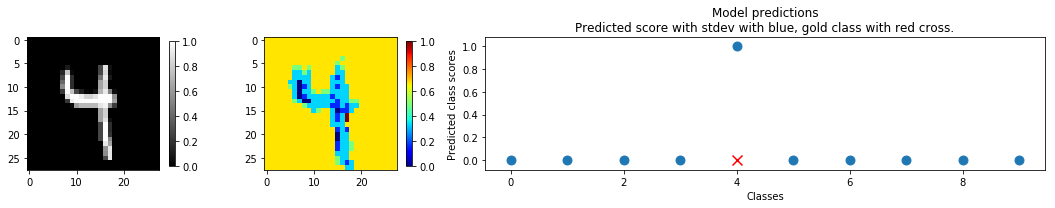

______________________________________________
Gold/Predicted value: 9 : 4
Std on prediction: 0.25487878918647766


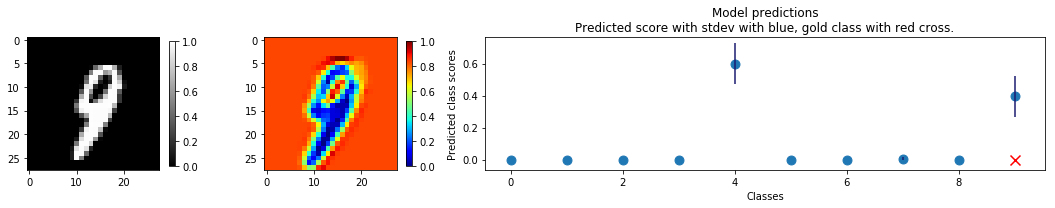

______________________________________________
Gold/Predicted value: 1 : 2
Std on prediction: 0.3307111859321594


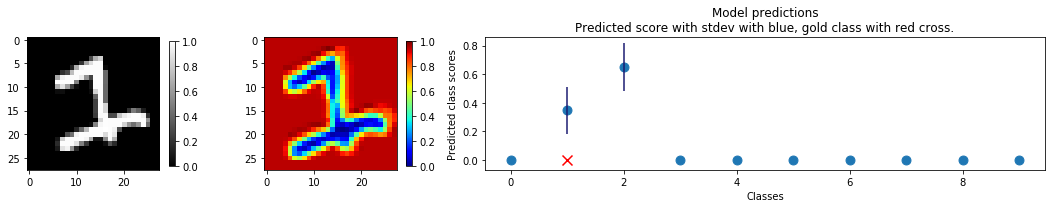

In [8]:
visualize_example(df, target_class=None, nb_of_pos_examples=1, nb_of_neg_examples=2)

# MNIST-Corrupted

In [9]:
def eval_on_mnist_corrupted_subset(model, subset, gradcam_target_layer='conv2d'):
    ds_test = tfds.load("mnist_corrupted/{}".format(subset), split='test', as_supervised=True)
    ds_test = ds_test.map(lambda img, label: (tf.cast(img,tf.float32) / 255.0, label))
    ds_test = ds_test.take(100)

    # Eval
    df_results = eval(model, ds_test, gradcam_target_layer=gradcam_target_layer)
    acc = df_results['gold'] == df_results['predicted']
    acc = acc.sum() / len(acc)
    
    return df_results, acc

## Spatter noise

In [10]:
df_spatter, acc_spatter = eval_on_mnist_corrupted_subset(model, 'spatter', gradcam_target_layer='conv2d')

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

Accuracy on MNIST Corrupted (Spatter) test set 0.97
______________________________________________
Gold/Predicted value: 0 : 0
Std on prediction: 1.0718654266383965e-05


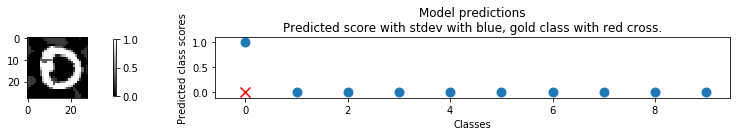

______________________________________________
Gold/Predicted value: 9 : 7
Std on prediction: 0.19557739794254303


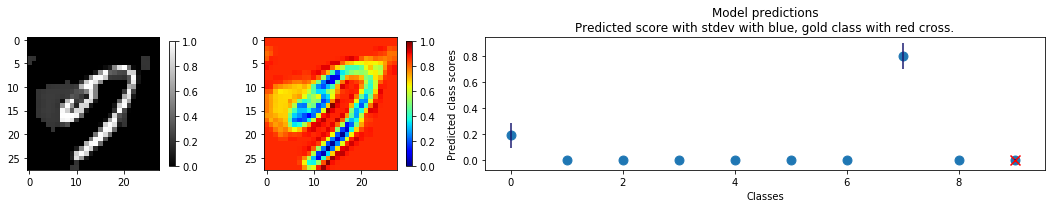

______________________________________________
Gold/Predicted value: 9 : 8
Std on prediction: 0.22546851634979248


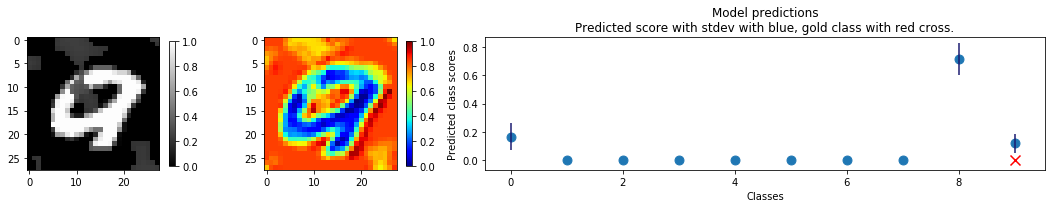

In [11]:
print("Accuracy on MNIST Corrupted (Spatter) test set {}".format(acc_spatter))
visualize_example(df_spatter, target_class=None, nb_of_pos_examples=1, nb_of_neg_examples=2)

## Fog noise

In [12]:
df_fog, acc_fog = eval_on_mnist_corrupted_subset(model, 'fog', gradcam_target_layer='conv2d')

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

Accuracy on MNIST Corrupted (Spatter) test set 0.13
______________________________________________
Gold/Predicted value: 0 : 0
Std on prediction: 0.22324064373970032


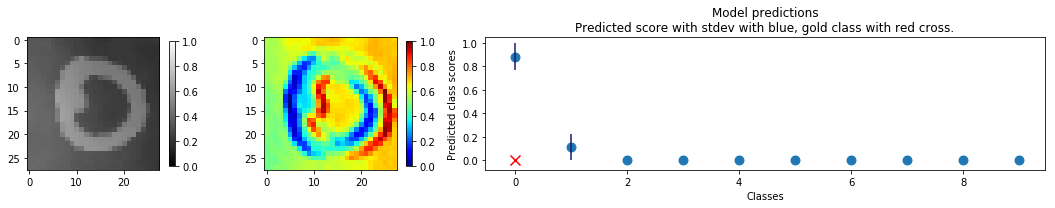

______________________________________________
Gold/Predicted value: 6 : 1
Std on prediction: 0.28693825006484985


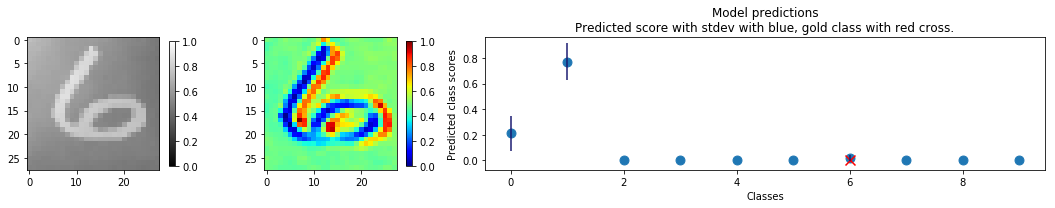

______________________________________________
Gold/Predicted value: 6 : 1
Std on prediction: 0.10184569656848907


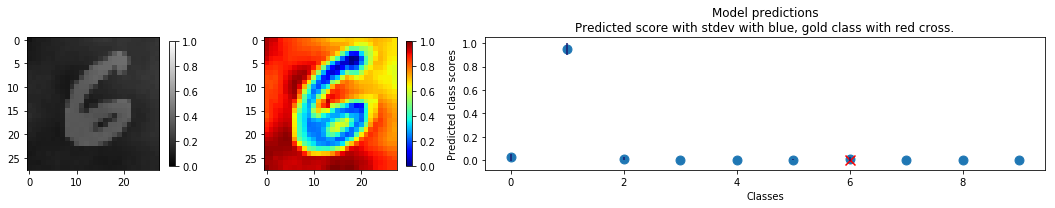

In [19]:
print("Accuracy on MNIST Corrupted (Spatter) test set {}".format(acc_fog))
visualize_example(df_fog, target_class=None, nb_of_pos_examples=1, nb_of_neg_examples=2)

## Canny Edges

In [14]:
df_canny, acc_canny = eval_on_mnist_corrupted_subset(model, 'canny_edges', gradcam_target_layer='conv2d')

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

Accuracy on MNIST Corrupted (Spatter) test set 0.59
______________________________________________
Gold/Predicted value: 6 : 6
Std on prediction: 0.0310312919318676


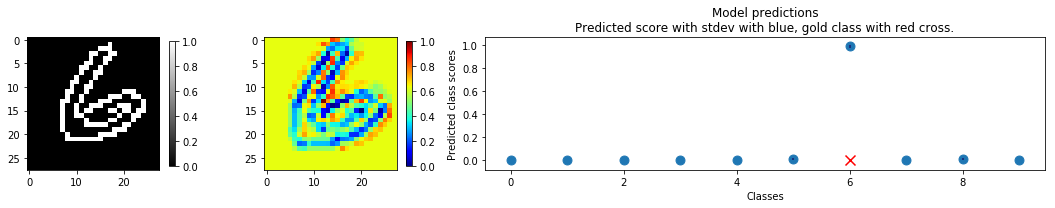

______________________________________________
Gold/Predicted value: 9 : 8
Std on prediction: 0.2805868089199066


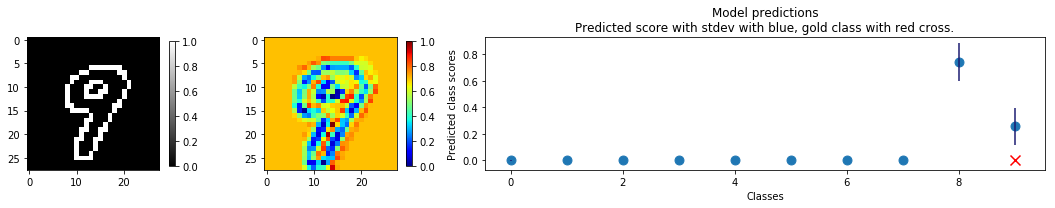

______________________________________________
Gold/Predicted value: 7 : 8
Std on prediction: 0.2307731956243515


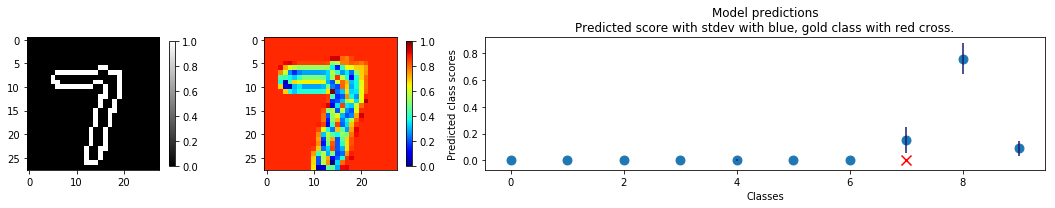

In [15]:
print("Accuracy on MNIST Corrupted (Spatter) test set {}".format(acc_canny))
visualize_example(df_canny, target_class=None, nb_of_pos_examples=1, nb_of_neg_examples=2)

## Brightness

In [16]:
df_brightness, acc_rightness = eval_on_mnist_corrupted_subset(model, 'brightness', gradcam_target_layer='conv2d')

/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz/git/uncertanity/src/dropout/mnist.py:75: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (cam - cam.min()) / (cam.max() - cam.min())
/home/dasz

Accuracy on MNIST Corrupted (Spatter) test set 0.78
______________________________________________
Gold/Predicted value: 4 : 4
Std on prediction: 0.22544865310192108


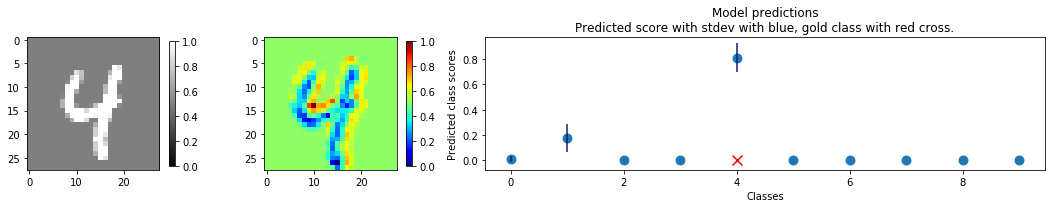

______________________________________________
Gold/Predicted value: 9 : 1
Std on prediction: 0.19953706860542297


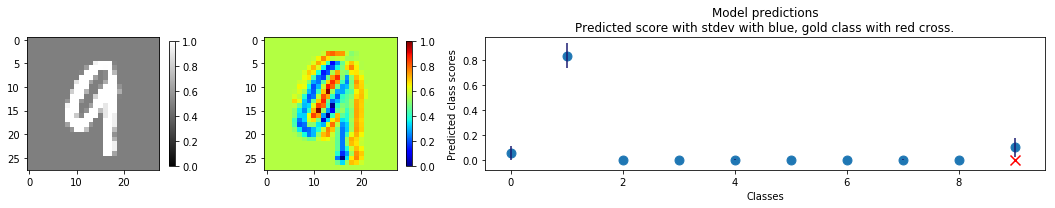

______________________________________________
Gold/Predicted value: 2 : 0
Std on prediction: 0.3076387047767639


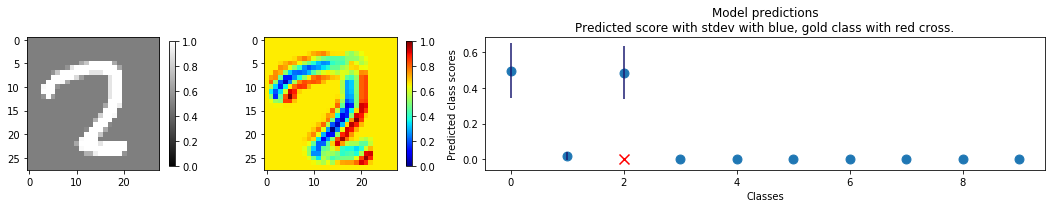

In [17]:
print("Accuracy on MNIST Corrupted (Spatter) test set {}".format(acc_rightness))
visualize_example(df_brightness, target_class=None, nb_of_pos_examples=1, nb_of_neg_examples=2)